In [12]:
import pandas as pd
import numpy as np
from numpy import random
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
import scipy
from scipy.stats import *
from datetime import datetime as dt

# Load Data
----------------

### Sentiment Data

In [13]:
df = pd.read_csv('sentiment.csv', usecols = [1,7,8])
df.Date = pd.to_datetime(df.Date)
df.Date = df.Date.dt.date
df = df.set_index(pd.DatetimeIndex(df.Date)).sort_index()
print(df.shape)
df.head()

(289, 3)


,Date,Positive Sentiment,Negative Sentiment
Date,,,
2013-12-19,2013-12-19,0.140625,-0.020833
2017-05-16,2017-05-16,0.187856,-0.034156
2017-05-26,2017-05-26,0.461538,-0.004525
2017-06-07,2017-06-07,0.181159,-0.007246
2017-06-21,2017-06-21,0.175000,-0.056250


The first thing we need to resolve is how to score dates that have more than one  Sentiment Score. This means there were several different articles parsed for that day. For instance, we can see below, September 8$^{th}$ had 4
different article parsed

In [14]:
df.sort_index().iloc[26:30]

,Date,Positive Sentiment,Negative Sentiment
Date,,,
2017-09-08,2017-09-08,0.368286,-0.002558
2017-09-08,2017-09-08,0.411765,0.000000
2017-09-08,2017-09-08,0.102857,-0.171429
2017-09-08,2017-09-08,0.102857,-0.171429


There's a few ways we can handle this situation. We can take the Average of these values to give an overall sentiment for the day. A better way to average values to better represent orders of magnitude of each individual value is the Root Mean Square (RMS) which is simplyt $\sqrt{x_1^2 + x_2^2 + ... + x_n^2}$. And finally, we can simply sum the values. After performing this aggregations, let's then combine the negative and positive sentiment score to create some meaningful "Overall Sentiment" for each day. We will do this by simply summing the Positive Sentiment and Negative Sentiment

In [15]:
#Average multiple sentiment values for a single day
df_mean = df.groupby(df.index).mean().rename(columns = {'Positive Sentiment':'Positive Sentiment Averaged', 'Negative Sentiment':'Negative Sentiment Averaged'})
df_mean['Overall Sentiment Averaged'] = df_mean['Positive Sentiment Averaged'] + df_mean['Negative Sentiment Averaged']

#Add multiple sentiment values for a single day
df_sum = df.groupby(df.index).sum().rename(columns = {'Positive Sentiment':'Positive Sentiment Summed', 'Negative Sentiment':'Negative Sentiment Summed'})
df_sum['Overall Sentiment Summed'] = df_sum['Positive Sentiment Summed'] + df_sum['Negative Sentiment Summed']

#Root Mean Square Average multiple sentiment values for a single day
df_rms = df.groupby(df.index).agg(lambda x: np.sqrt(np.mean(x**2))).rename(columns = {'Positive Sentiment':'Positive Sentiment RMS', 'Negative Sentiment':'Negative Sentiment RMS'})
df_rms['Negative Sentiment RMS'] = -df_rms['Negative Sentiment RMS']
df_rms['Overall Sentiment RMS'] = df_rms['Positive Sentiment RMS'] + df_rms['Negative Sentiment RMS']

In [16]:
df = pd.concat([df_mean,df_sum,df_rms], axis = 1)
df.head()

,Positive Sentiment Averaged,Negative Sentiment Averaged,Overall Sentiment Averaged,Positive Sentiment Summed,Negative Sentiment Summed,Overall Sentiment Summed,Positive Sentiment RMS,Negative Sentiment RMS,Overall Sentiment RMS
Date,,,,,,,,,
2013-12-19,0.140625,-0.020833,0.119792,0.140625,-0.020833,0.119792,0.140625,-0.020833,0.119792
2017-05-16,0.187856,-0.034156,0.153700,0.187856,-0.034156,0.153700,0.187856,-0.034156,0.153700
2017-05-26,0.461538,-0.004525,0.457014,0.461538,-0.004525,0.457014,0.461538,-0.004525,0.457014
2017-06-07,0.181159,-0.007246,0.173913,0.181159,-0.007246,0.173913,0.181159,-0.007246,0.173913
2017-06-21,0.175000,-0.056250,0.118750,0.175000,-0.056250,0.118750,0.175000,-0.056250,0.118750


So now we have the following values for September 8$^{th}$

In [17]:
df.sort_index().iloc[25:26]

,Positive Sentiment Averaged,Negative Sentiment Averaged,Overall Sentiment Averaged,Positive Sentiment Summed,Negative Sentiment Summed,Overall Sentiment Summed,Positive Sentiment RMS,Negative Sentiment RMS,Overall Sentiment RMS
Date,,,,,,,,,
2017-09-08,0.246441,-0.086354,0.160088,0.985765,-0.345415,0.640351,0.285633,-0.121225,0.164408


### Historical Price Data

In [18]:
df2 = pd.read_csv('historical_pricing.csv', header = [0,1]).rename(columns = {'Unnamed: 0_level_1':'Date'}).iloc[1:,:]
df2 = df2.set_index(pd.DatetimeIndex(df2.Coin.Date))
df2.sort_index().head()

Coin      XRP                                          \
                  Date Change %    High     Low    Open   Price    Vol.   
Date                                                                      
2017-08-01  2017-08-01    9.57%  0.1850  0.1585  0.1630  0.1786  26.82M   
2017-08-02  2017-08-02   -4.59%  0.1800  0.1680  0.1786  0.1704  11.47M   
2017-08-03  2017-08-03    2.46%  0.1772  0.1688  0.1704  0.1746   4.59M   
2017-08-04  2017-08-04   -0.57%  0.1780  0.1710  0.1746  0.1736   7.21M   
2017-08-05  2017-08-05    5.99%  0.1920  0.1710  0.1736  0.1840  20.38M   

                BTC                                              ETH          \
           Change %    High     Low    Open   Price    Vol. Change %    High   
Date                                                                           
2017-08-01   -4.37%  2901.6  2615.8  2854.3  2731.2  42.31K   12.53%  232.59   
2017-08-02   -1.07%  2757.8  2640.0  2733.8  2702.0  23.76K   -3.53%  229.70   
2017-08-03    3.27%  2813.0  2698.0  2702.0  2790.3  16.86K    3.11%  228.20   
2017-08-04    2.50%  2874.8  2762.6  2790.3  2860.0  18.99K   -1.81%  228.30   
2017-08-05   13.86%  3331.9  2855.0  2860.0  3256.4  50.56K   15.01%  259.90   

                                             
               Low    Open   Price     Vol.  
Date                                         
2017-08-01  200.80  200.81  225.97  352.31K  
2017-08-02  215.00  225.97  218.00  159.47K  
2017-08-03  217.07  218.00  224.79   96.19K  
2017-08-04  218.66  224.79  220.73   83.46K  
2017-08-05  219.23  220.73  253.87  234.87K

The Historical Price DataFrame is MultiIndex one which can be difficult to work with. Also There are a lot of non numerical values that need to be converted. We want to combine both the sentiment DataFrame with the Historical Price DataFrame. Also we are trying to see the relationship between all variables and how they affect the next day's XRP Price. Because of this, we need to shift XRP's values up by one day so that all variables from today are inline with XRP Variables for tomorrow. This merged DataFrame needs some cleaning up so let's perform the following:
* Perform full outer join between Sentiment DataFrame and Historical Prices DataFrame
* Rename columns and convert to a single level index column DataFrame
* Convert Change % and Volume columns to numerical comlumns
* Volume amongst the 3 coins are at two different magnitudes (XRP in M, BTC/ETH in K) so convert XRP Volume to a magnitude of thousands
* Shift XRP values up by one day

In [19]:
#Full Outer Join
df3 = pd.merge(df, df2, how = 'outer', left_index = True, right_index = True).replace(np.NaN,0).iloc[7:-1]
#Rename Columns to convert to single level index
df3 = df3.rename(columns = {('Coin','Date'):'date',
                      ('XRP','Change %'):'XRP_Change',
                      ('XRP','High'):'XRP_High',
                      ('XRP','Low'): 'XRP_Low', 
                      ('XRP','Open'): 'XRP_Open',
                      ('XRP','Price'): 'XRP_Price',
                      ('XRP','Vol.'): 'XRP_Vol',
                      ('BTC','Change %'): 'BTC_Change',
                      ('BTC','High'): 'BTC_High',
                      ('BTC','Low'): 'BTC_Low',
                      ('BTC','Open'): 'BTC_Open',
                      ('BTC','Price'): 'BTC_Price',
                      ('BTC','Vol.'): 'BTC_Vol',
                      ('ETH','Change %'): 'ETH_Change',
                      ('ETH','High'): 'ETH_High',
                      ('ETH','Low'): 'ETH_Low',
                      ('ETH','Open'): 'ETH_Open',
                      ('ETH','Close'): 'ETH_Close',
                      ('ETH','Price'): 'ETH_Price',
                      ('ETH','Vol.'): 'ETH_Vol'}).drop('date', axis = 1)
#Convert Volume and Change % to numeric values
df3.XRP_Change = pd.to_numeric(df3.XRP_Change.str.replace('%',''))
df3.BTC_Change = pd.to_numeric(df3.BTC_Change.str.replace('%',''))
df3.ETH_Change = pd.to_numeric(df3.ETH_Change.str.replace('%',''))
df3.XRP_Vol = pd.to_numeric(df3.XRP_Vol.str.replace('M',''))
df3.BTC_Vol = pd.to_numeric(df3.BTC_Vol.str.replace('K',''))
df3.ETH_Vol = pd.to_numeric(df3.ETH_Vol.str.replace('K','').replace('-',0))

/home/scott/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/merge.py:558: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


Create a function that will convert the XRP Volume from magnitude in the millions to magnitude in the thousands

In [20]:
def convert_thousands(x):
    x = (x * 1000000) / 1000
    return x

In [21]:
#Convert XRP Volume to thousands
df3.XRP_Vol = df3.XRP_Vol.apply(lambda x: convert_thousands(x))
#Shift XRP Values up by one day
df3[['XRP_Change','XRP_Price']] = df3[['XRP_Change','XRP_Price']].shift(-1).replace(np.NaN,0)

In [25]:
df3.head()

,Positive Sentiment Averaged,Negative Sentiment Averaged,Overall Sentiment Averaged,Positive Sentiment Summed,Negative Sentiment Summed,Overall Sentiment Summed,Positive Sentiment RMS,Negative Sentiment RMS,Overall Sentiment RMS,XRP_Change,...,BTC_Low,BTC_Open,BTC_Price,BTC_Vol,ETH_Change,ETH_High,ETH_Low,ETH_Open,ETH_Price,ETH_Vol
Date,,,,,,,,,,,,,,,,,,,,,
2017-08-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.59,...,2615.8,2854.3,2731.2,42.31,12.53,232.59,200.80,200.81,225.97,352.31
2017-08-02,0.176871,-0.072562,0.104308,0.176871,-0.072562,0.104308,0.176871,-0.072562,0.104308,2.46,...,2640.0,2733.8,2702.0,23.76,-3.53,229.70,215.00,225.97,218.00,159.47
2017-08-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.57,...,2698.0,2702.0,2790.3,16.86,3.11,228.20,217.07,218.00,224.79,96.19
2017-08-04,0.163616,-0.102975,0.060641,0.163616,-0.102975,0.060641,0.163616,-0.102975,0.060641,5.99,...,2762.6,2790.3,2860.0,18.99,-1.81,228.30,218.66,224.79,220.73,83.46
2017-08-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.01,...,2855.0,2860.0,3256.4,50.56,15.01,259.90,219.23,220.73,253.87,234.87


# EDA

Now that we have acquired and wrangled our data, let's perform our EDA. Our ultimate goal is to see how all the data affects XRP Price and possibly XRP Price Change %. As one should always do, let's explore the statistics for each column. The DataFrame is pretty wide, so in order to all columns, we will have to break the DataFrame up into groups

In [26]:
df3.iloc[:,0:9].describe()

,Positive Sentiment Averaged,Negative Sentiment Averaged,Overall Sentiment Averaged,Positive Sentiment Summed,Negative Sentiment Summed,Overall Sentiment Summed,Positive Sentiment RMS,Negative Sentiment RMS,Overall Sentiment RMS
count,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000
mean,0.119831,-0.068976,0.050855,0.270523,-0.111363,0.159160,0.126973,-0.074879,0.052093
std,0.149848,0.104154,0.185771,0.513900,0.176829,0.488109,0.158875,0.107986,0.190068
min,0.000000,-0.550725,-0.521739,0.000000,-1.015394,-0.893821,0.000000,-0.550725,-0.521739
25%,0.000000,-0.107745,0.000000,0.000000,-0.180891,0.000000,0.000000,-0.121225,0.000000
50%,0.066316,-0.007937,0.000000,0.069204,-0.009081,0.000000,0.066316,-0.008721,0.000000
75%,0.192420,0.000000,0.122988,0.291498,0.000000,0.177928,0.213527,0.000000,0.120408
max,0.750000,0.000000,0.750000,3.176055,0.000000,2.847496,0.750000,0.000000,0.750000


In [27]:
df3.iloc[:,9:-1].describe()

,XRP_Change,XRP_High,XRP_Low,XRP_Open,XRP_Price,XRP_Vol,BTC_Change,BTC_High,BTC_Low,BTC_Open,BTC_Price,BTC_Vol,ETH_Change,ETH_High,ETH_Low,ETH_Open,ETH_Price
count,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000
mean,0.862332,0.667125,0.562797,0.618025,0.618504,21304.347826,0.516759,8723.356680,7873.239842,8340.126047,8355.912451,55.282727,0.484743,574.766719,516.038182,547.875020,548.718103
std,10.424431,0.633961,0.502694,0.572423,0.572150,22884.212987,5.867157,4195.190567,3634.954020,3972.692520,3958.264265,30.153092,6.283129,310.035083,268.951532,292.417849,291.726532
min,-30.960000,0.160800,0.145500,0.152500,0.000000,1460.000000,-18.440000,2757.800000,2615.800000,2702.000000,2702.000000,11.160000,-20.180000,228.200000,198.000000,200.810000,218.000000
25%,-3.780000,0.214700,0.197500,0.205000,0.205700,7210.000000,-2.900000,4672.800000,4400.500000,4586.600000,4589.100000,34.440000,-2.310000,312.000000,292.300000,303.200000,303.440000
50%,-0.330000,0.281000,0.242000,0.257800,0.258300,14310.000000,0.400000,8209.000000,7511.100000,7832.000000,7851.000000,48.970000,0.070000,429.000000,387.310000,405.190000,413.710000
75%,3.230000,0.967100,0.850010,0.903880,0.903880,23630.000000,3.840000,11383.000000,10224.000000,10908.000000,10925.000000,66.660000,3.900000,848.080000,725.010000,786.970000,786.970000
max,81.150000,3.280000,2.560000,2.770670,2.770000,143370.000000,22.720000,19891.000000,18622.000000,19210.000000,19187.000000,192.760000,23.220000,1423.200000,1264.400000,1379.900000,1380.000000


First thing to notice is the magnitude of each column. Sentiment is as low as 0 whereas XRP Volume is as high as 143,370. Because of this, eventually we will need to scale our data. Secondly, XRP was as low as 15 cents and reached a maximum of 3.28 during an intraday trading session. A $1,000 investment at that initial price point would've netted a return of almost 22,000 at XRP's highest price point. Volume of XRP has also been pretty volatile swinging from 1,460,000 to as high as 143,370,000. Hopefully our sentiment will lend some insight as to what caused such volatility in volume trading. We will start off as XRP Price and Price Change % as our main focal point and jump straight in with correlations. Let's create a correlation matrix to see which set of variables has the highest correlation with XRP Price movement.

In [28]:
corr_matrix = df3.corr()
corr_matrix[['XRP_Price', 'XRP_Change']]

,XRP_Price,XRP_Change
Positive Sentiment Averaged,0.287620,0.076341
Negative Sentiment Averaged,-0.190310,0.059758
Overall Sentiment Averaged,0.125304,0.095083
Positive Sentiment Summed,0.474611,-0.004094
Negative Sentiment Summed,-0.363759,0.021691
Overall Sentiment Summed,0.367908,0.003548
Positive Sentiment RMS,0.306076,0.073217
Negative Sentiment RMS,-0.226736,0.055611
Overall Sentiment RMS,0.127025,0.092796
XRP_Change,0.066227,1.000000


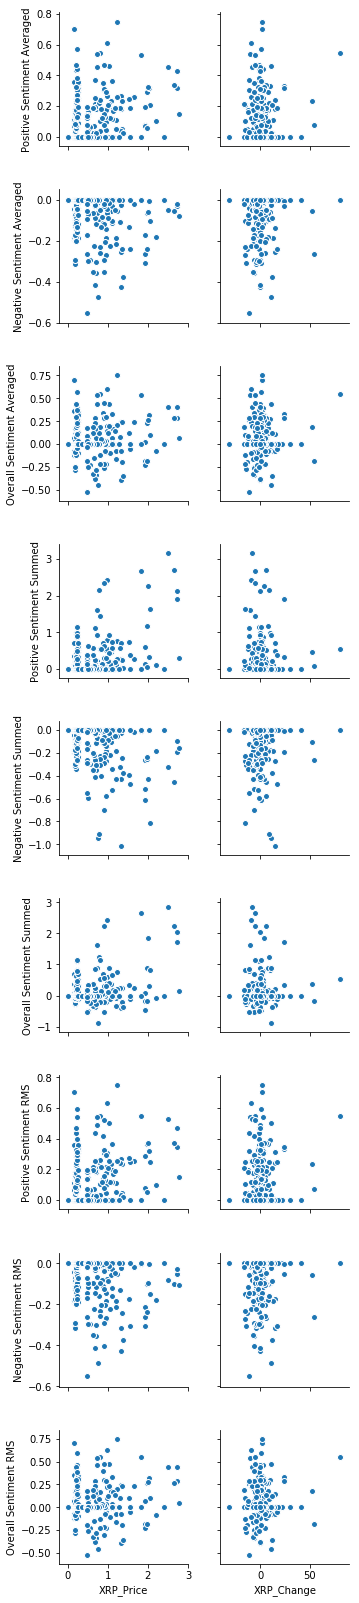

In [29]:
sns.pairplot(df3, x_vars = ['XRP_Price','XRP_Change'], y_vars = [df3.columns[i] for i in range(9)])
plt.show()

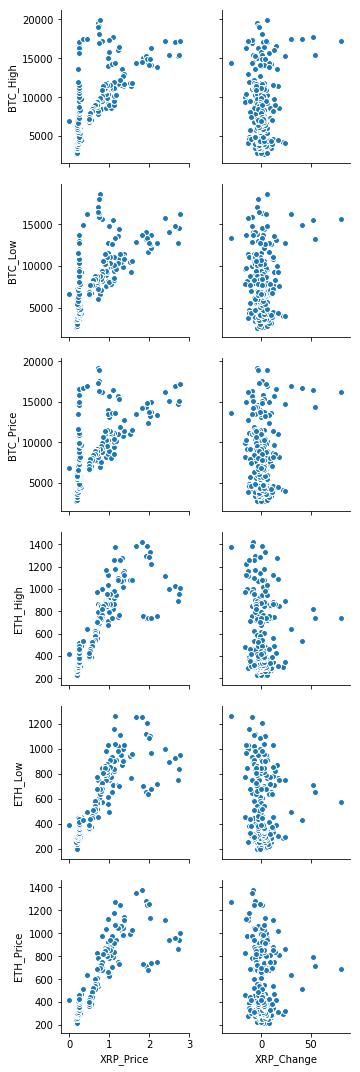

In [30]:
sns.pairplot(df3, x_vars = ['XRP_Price','XRP_Change'], y_vars = ['BTC_High','BTC_Low','BTC_Price','ETH_High','ETH_Low','ETH_Price'])
plt.show()

In relation to Sentiment, the Positive Sentiment Summed appears to have the strongest correlation with XRP Price than all the other methods of aggregation. Conversely the Overall Sentiment Summed also has the highest correlation than all other Overall Sentiment aggregates. We will visualize these relationships later. With respect to all historical price statistics, surprisingly ETH has the highest correlation with XRP Price. This is surpising because more exchanges allow trading with BTC than any other cryptocurrency. When looking at the market as whole, it always tends to follow the trend of BTC. However XRP appears to not follow that paradigm as strongly as other coins. Conversely, with respect to XRP Price Change %, all correlations are very weak. This might have something to do with a "day to day" price change. Maybe if we leveraged a 5 or 10 day Price Change %, that might lend to some more insights to how all variables relate to percentage change. We will investigate this further when we hone in more on Sentiment and Price relationships later. First, let's visualize the price points of all 3 coins to visualize the surpising trend that XRP follows ETH more closely than BTC. First, Remember the differing magnitudes for the prices of each coin. Because they vary so greatly, we need to normalize all values to 1. Using MinMaxScaler from Sci-Kit Learn will help with this normalization

In [31]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = df3.loc[:,['XRP_Price','BTC_Price','ETH_Price']]
data = scaler.fit_transform(data)
scaled_data = pd.DataFrame(data, columns = ['XRP','BTC','ETH']).set_index(df3.index)
scaled_data.head()

,XRP,BTC,ETH
Date,,,
2017-08-01,0.061516,0.001771,0.006859
2017-08-02,0.063032,0.000000,0.000000
2017-08-03,0.062671,0.005356,0.005843
2017-08-04,0.066426,0.009584,0.002349
2017-08-05,0.065090,0.033631,0.030869


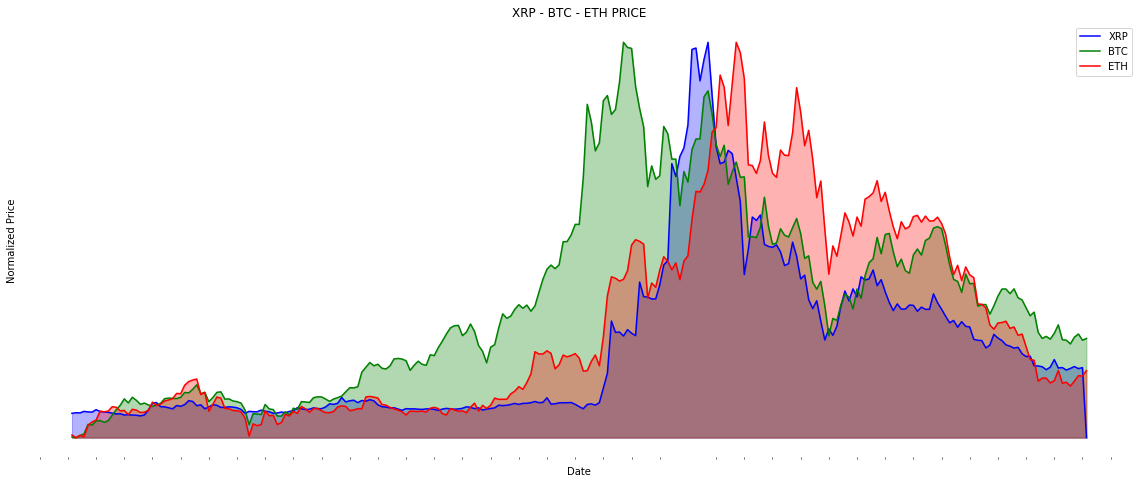

In [32]:
ax = scaled_data.plot(figsize = (20,8), color = ['blue','green','red'])
ax.fill_between(scaled_data.index, np.zeros(len(scaled_data)),scaled_data.XRP, color = 'blue', alpha = 0.3)
ax.fill_between(scaled_data.index, np.zeros(len(scaled_data)),scaled_data.BTC, color = 'green', alpha = 0.3)
ax.fill_between(scaled_data.index, np.zeros(len(scaled_data)),scaled_data.ETH, color = 'red', alpha = 0.3)

ax.set_xlabel('Date')
ax.set_ylabel('Normalized Price')
ax.set_title('XRP - BTC - ETH PRICE')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
plt.show()

It appears that XRP trails price fluctuations in ETH by a day or two. However both coins can trail BTC by up to a week or more it appears. This is interesting because not only as stated earlier, the market as  whole tends to follow BTC, but also the trading volume of XRP was much greater than both coins combined. BTC and ETH traded in the hundreds of thousands whereas XRP traded in the millions. Although this could simply be due to the price point differences. BTC average price was 8300 where ETH average was about 550 and XRP average hovered around 0.62. Therefore a dollar has more buying power in terms of XRP, but one could speculate with volume in the hundreds of millions, demand is high therefore price should be as well.

Remember that ETH High and Low had a higher correlation with XRP Price than any other metric. Let's explore these variables further. Again we must scale these values as we did with the prices above

In [33]:
scaler = MinMaxScaler()
data = scaler.fit_transform(df3[['BTC_High','BTC_Low','ETH_High','ETH_Low','XRP_Price']])
data = pd.DataFrame(data, columns = ['BTC_High','BTC_Low','ETH_High','ETH_Low','XRP_Price'], index = df3.index)

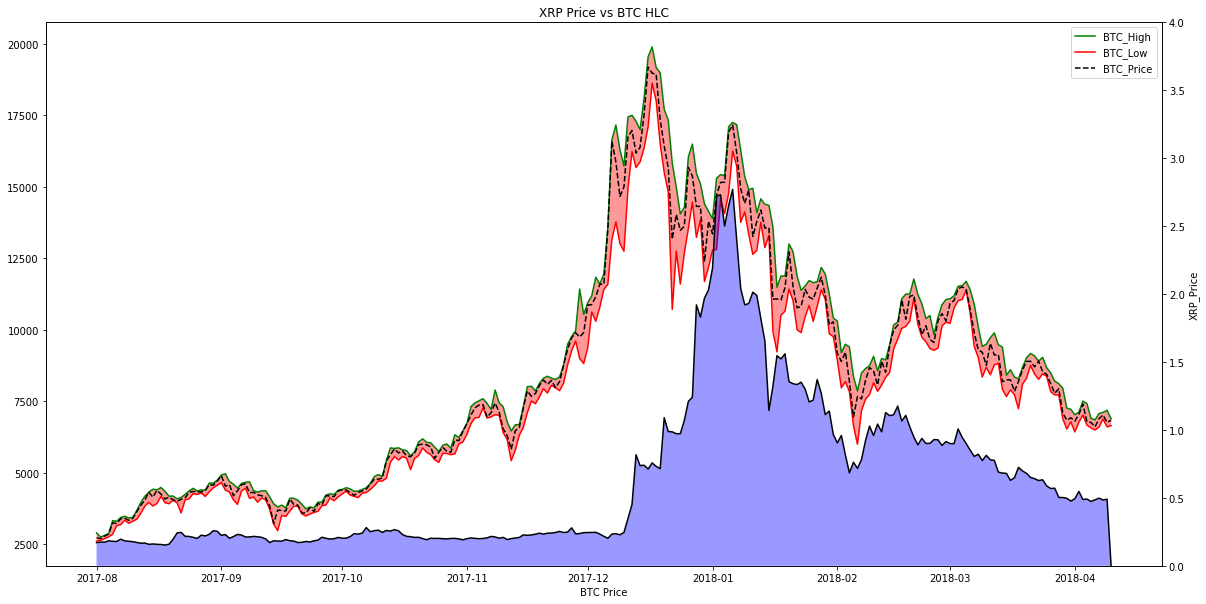

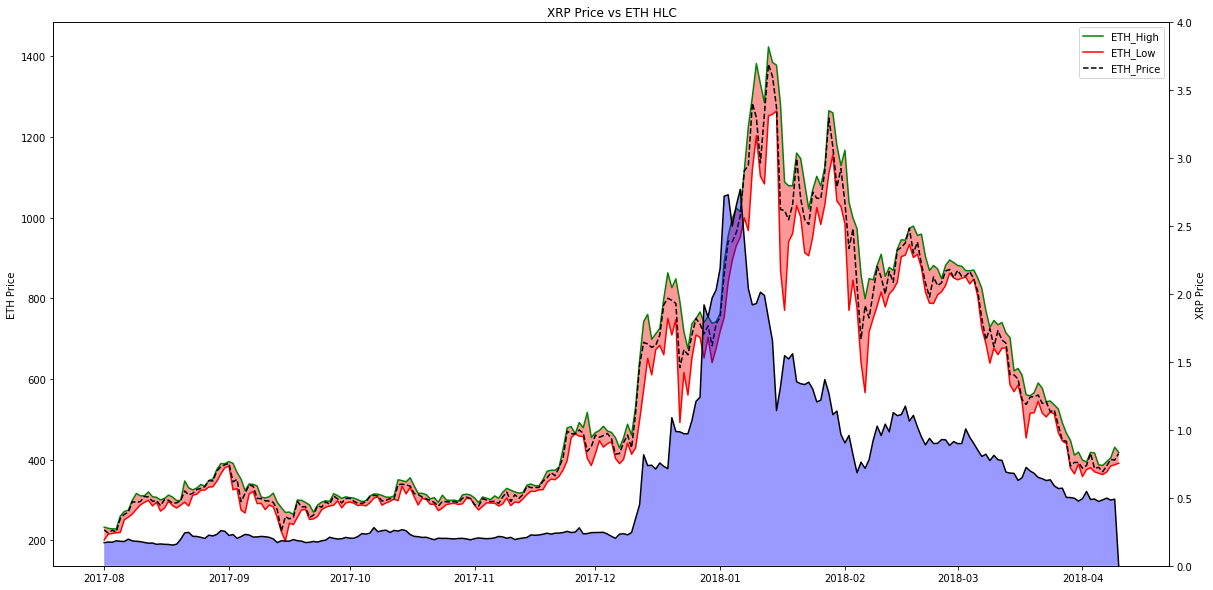

In [34]:
plt.figure(figsize = (20,10))
ax = plt.subplot()
ax.plot(df3.index, df3.BTC_High, color = 'g')
ax.plot(df3.index, df3.BTC_Low, color = 'r')
ax.plot(df3.index, df3.BTC_Price, color = 'k', linestyle = '--')
ax.fill_between(df3.index, df3.BTC_Low,df3.BTC_High, facecolor = 'r', alpha =0.4)
ax.set_xlabel('BTC Price')
ax.legend()
ax.set_title('XRP Price vs BTC HLC')
ax2 = ax.twinx()
ax2.plot(df3.index, df3.XRP_Price, color = 'k')
ax2.fill_between(df3.index, np.zeros(len(df3)), df3.XRP_Price, facecolor = 'b', alpha = 0.4)
ax2.set_ylim([0,4])
ax2.set_ylabel('XRP_Price')
plt.show()


plt.figure(figsize = (20,10))
ax = plt.subplot()
ax.plot(df3.index, df3.ETH_High, color = 'g')
ax.plot(df3.index, df3.ETH_Low, color = 'r')
ax.plot(df3.index, df3.ETH_Price, color = 'k', linestyle = '--')
ax.fill_between(df3.index, df3.ETH_Low,df3.ETH_High, facecolor = 'r', alpha =0.4)
ax.set_ylabel('ETH Price')
ax.set_title('XRP Price vs ETH HLC')
ax.legend()
ax2 = ax.twinx()
ax2.plot(df3.index, df3.XRP_Price, color = 'k')
ax2.fill_between(df3.index, np.zeros(len(df3)), df3.XRP_Price, facecolor = 'b', alpha = 0.4)
ax2.set_ylim([0,4])
ax2.set_ylabel('XRP Price')

plt.show()

No further trend is being revealed when breaking down BTC and ETH down to they're respective constituents of High and Low Prices. One thing to note however is that both ETH and XRP really exploded after BTC fell from it's highest high. This could be interpreted as investors rode the BTC surge until it began to fall from it's highs, then investors pivoted to other coins such as XRP and BTC. 

Next Let's analyzed how price responds to sentiment. Remember that we created three aggregates of sentiment {summed, averaged, RMS}. Since RMS is a form of averaging, their values will be somewhat close to each other. Therefore it might be a bit redundant to analyze both at the same time. Let's focus on summed and RMS, and if RMS appears to show more insight than summed, then we will incorporate averaged statistics. First let's extract the linear regression line for Sentiment and Price then plot the bivariate distributions for Sentiment Summed and Sentiment RMS vs XRP Price

In [35]:
#Extract slope and intercept terms for linear regression line
slope_p, intercept_p, r_value_p, p_value_p, std_err_p = scipy.stats.linregress(df3['Positive Sentiment Summed'], df3.XRP_Price)
slope_n, intercept_n, r_value_n, p_value_n, std_err_n = scipy.stats.linregress(df3['Negative Sentiment Summed'], df3.XRP_Price)
y_p = (slope_p * df3['Positive Sentiment Summed']) + intercept_p
y_n = (slope_n * df3['Negative Sentiment Summed']) + intercept_n

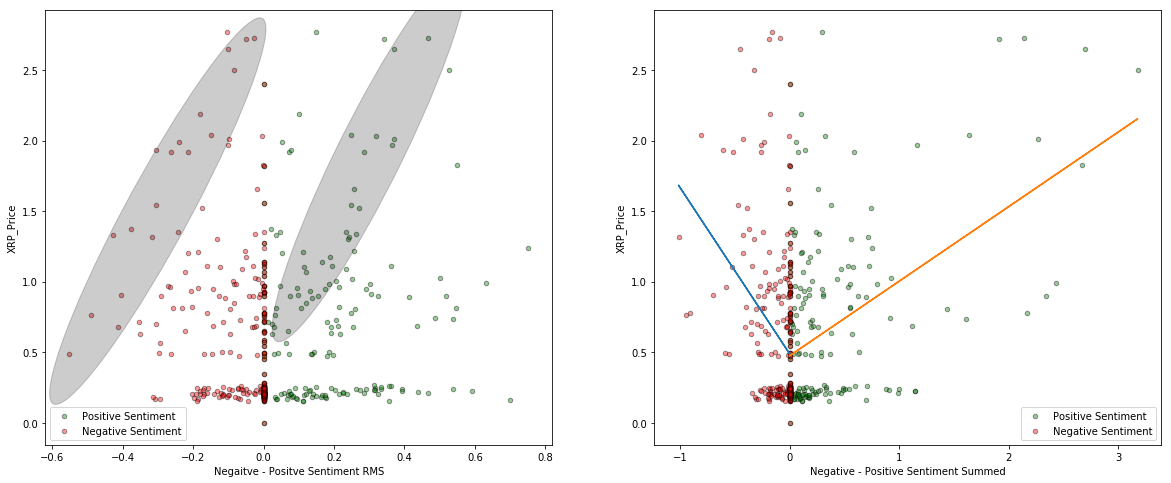

In [36]:
plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))

ax1 = plt.subplot(121)
df3.plot(x = 'Positive Sentiment RMS', y = 'XRP_Price', kind = 'scatter', color = 'g', alpha = 0.4, edgecolor = 'k', ax = ax1)
df3.plot(x = 'Negative Sentiment RMS', y = 'XRP_Price', kind = 'scatter', color = 'r', alpha = 0.4, edgecolor = 'k', ax = ax1)
ax1.legend(['Positive Sentiment','Negative Sentiment'])
ax1.set_xlabel('Negaitve - Positve Sentiment RMS')
ax1.add_patch(patches.Ellipse((-0.3,1.5), 0.2, 2.8, angle = 348, alpha = 0.2, color = 'k'))
ax1.add_patch(patches.Ellipse((0.3,1.9), 0.2, 2.7, angle = 349, alpha = 0.2, color = 'k'))

ax2 = plt.subplot(122)
df3.plot(x = 'Positive Sentiment Summed', y = 'XRP_Price', kind = 'scatter', color = 'g', alpha = 0.4, edgecolor = 'k', ax = ax2)
df3.plot(x = 'Negative Sentiment Summed', y = 'XRP_Price', kind = 'scatter', color = 'r', alpha = 0.4, edgecolor = 'k', ax = ax2)
ax2.set_xlabel('Negative - Positive Sentiment Summed')
ax2.legend(['Positive Sentiment','Negative Sentiment'])
ax2.plot(df3['Negative Sentiment Summed'], y_n)
ax2.plot(df3['Positive Sentiment Summed'], y_p)

plt.show()

Interestingly enough, visually we can see a trend that we would expect to see in the gray ovals for the bivariate distribution on the left. The trend can also be seen in the distribution on the right, but is only highlighted in the left. As the negative sentiment increases in the negative direction, there is somewhat of a trend as expected (price decreasing). Conversely, with increasing positive sentiment, the XRP price is increasing. However, due to the clusters of both negative and positive points around the lowest XRP_Price, the actual linear regression line is being affected. It's producing a trend we wouldn't expect to see as presented in the distribution on the right (with increasing negative sentiment, increasing XRP Price). However, qualitatively examining both distributions, it is clear that the RMS statistic might be too sensitive to change and isn't very representative of how sentiment should be affecting price. For example, a positive sentiment of 0.5 can result in a price below 0.5 or a price as high as 2.6. Whereas utilizing Summed Sentiment, a sentiment of 3 should only, and does translate to a high XRP Price value. Next we will perform a time series analysis on price and Sentiment. We will start off by plotting price with both Positive and negative sentiment.

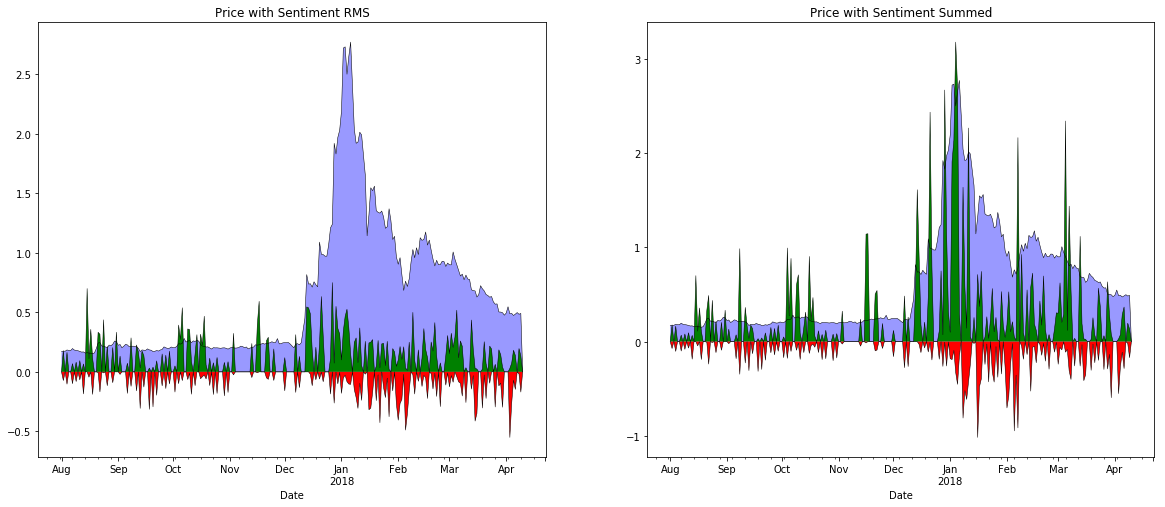

In [37]:
plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))

ax1 = plt.subplot(121)
df3.XRP_Price.plot(color = 'k', lw =0.5, ax = ax1)
ax1.fill_between(df3.index, np.zeros(len(df3)), df3.XRP_Price, alpha = 0.4, facecolor = 'b')

df3['Positive Sentiment RMS'].plot(ax = ax1, color = 'k', lw = 0.5)
ax1.fill_between(df3.index, np.zeros(len(df3)), df3['Positive Sentiment RMS'], facecolor = 'g')

df3['Negative Sentiment RMS'].plot(ax = ax1, color = 'k', lw = 0.5)
ax1.fill_between(df3.index, np.zeros(len(df3)), df3['Negative Sentiment RMS'], facecolor = 'r')

ax1.set_title('Price with Sentiment RMS')



ax2 = plt.subplot(122)
df3.XRP_Price.plot(color = 'k', lw =0.5, ax = ax2)
ax2.fill_between(df3.index, np.zeros(len(df3)), df3.XRP_Price, alpha = 0.4, facecolor = 'b')

df3['Positive Sentiment Summed'].plot(ax = ax2 , color = 'k', lw = 0.5)
ax2.fill_between(df3.index, np.zeros(len(df3)), df3['Positive Sentiment Summed'], facecolor = 'g')

df3['Negative Sentiment Summed'].plot(ax = ax2, color = 'k', lw = 0.5)
ax2.fill_between(df3.index, np.zeros(len(df3)), df3['Negative Sentiment Summed'], facecolor = 'r')

ax2.set_title('Price with Sentiment Summed')

plt.show()

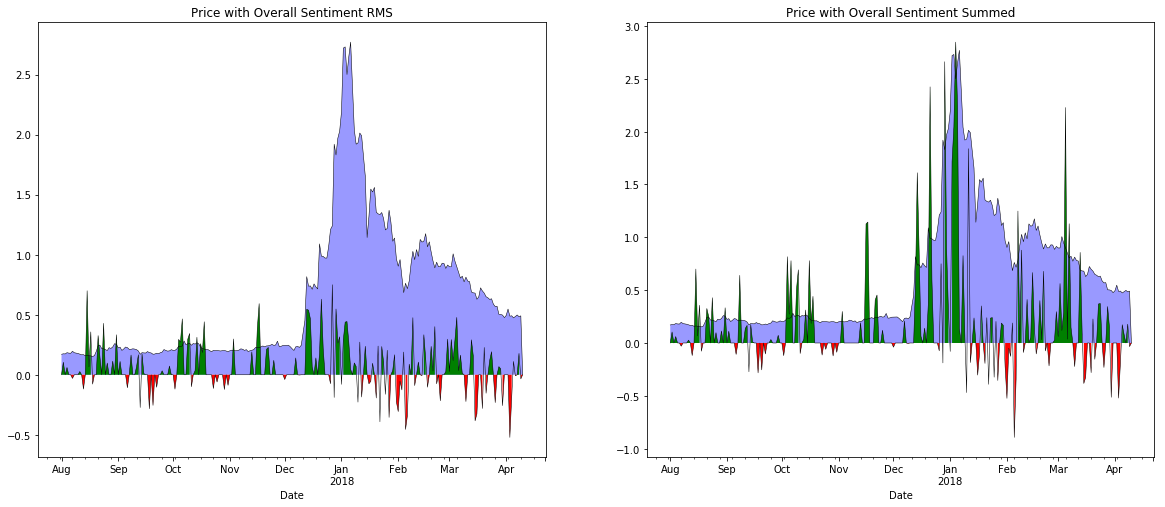

In [38]:
plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))

ax1 = plt.subplot(121)
df3.XRP_Price.plot(color = 'k', lw = 0.5, ax = ax1)
ax1.fill_between(df3.index, np.zeros(len(df3)), df3.XRP_Price, alpha = 0.4, facecolor = 'b')
df3['Overall Sentiment RMS'].plot(ax = ax1, color = 'k', lw = 0.5)
ax1.fill_between(df3.index, np.zeros(len(df3)), df3['Overall Sentiment RMS'], where = (df3['Overall Sentiment RMS'] >=0), facecolor = 'g')
ax1.fill_between(df3.index, np.zeros(len(df3)), df3['Overall Sentiment RMS'], where = (df3['Overall Sentiment RMS'] <=0), facecolor = 'r')
ax1.set_title('Price with Overall Sentiment RMS')

ax2 = plt.subplot(122)
df3.XRP_Price.plot(color = 'k', lw = 0.5, ax = ax2)
ax2.fill_between(df3.index, np.zeros(len(df3)), df3.XRP_Price, alpha = 0.4, facecolor = 'b')
df3['Overall Sentiment Summed'].plot(ax = ax2, color = 'k', lw = 0.5)
ax2.fill_between(df3.index, np.zeros(len(df3)), df3['Overall Sentiment Summed'], where = (df3['Overall Sentiment Summed'] >=0), facecolor = 'g')
ax2.fill_between(df3.index, np.zeros(len(df3)), df3['Overall Sentiment Summed'], where = (df3['Overall Sentiment Summed'] <=0), facecolor = 'r')
ax2.set_title('Price with Overall Sentiment Summed')
plt.show()


Again, we can see that Sentiment RMS doesn't translate very well to a change in XRP price like Sentiment Summed does. At XRP's highest Price point, Sentiment RMS has a value no higher than when XRP's price point was close to it's lowest. Sentiment Summed however, does reflect a huge leap in XRP Price at the same instance Sentiment explodes as well. However take note that these sentiments are purely day to day sentiments. But when an investor is investing, they wouldn't only look at articles on the day they were investing. They would research days, and sometimes weeks prior to determine sentiment and performance. Therefore, a days sentiment should also reflect previous days' sentiment as well. This will not only help smooth out the sentiment curve, but take into account for all 0 values of sentiment that the sentiment might not actually be 0. A value of 0 can simply mean that no article was written on that day, so Sentiment from a previous day would simply roll into that day. If There had been extremely high sentiment for the past week, but today there were no articles written on XRP, that doesn't mean that Sentiment on the coin has dropped within the market, it just simply means that no article was written today on the coin. We must account for this. It's not unreasonable to speculate that an investor might look at a coins weekly performance when determining strategy. Therefore, let's perform a 5 day rolling average for sentiment. When averaging the values however, yesterday's value being averaged into today will be it's original value, not it's rolling average value from when the 5 day average was performed on it. For example if we were performing a 3 day rolling average:
> Day 20 - Original Value: 2   |   3-Day Average: 2.7

> Day 21 - Original Value: 1   |   3-Day Average: 2.5 

> Day 23 - Original Value: 4  |   3-Day Average: 3.5

Notice from day 3, it got it's 3 day average from the original values of the previous 2 days, not their 3 Day Average

In [39]:
def boxfilter(df,col):
    #create copies so as to not overwrite original dataframe
    c = df.copy()
    c = c[col]
    #create a copy of c called d in order to overwrite with averages, while c maintains original values
    d = c.copy()
    for i in range(4,len(c)):
        d[i] = np.mean((c[i],c[i-1],c[i-2], c[i-3], c[i-4]))
    
    #create new column to write to dataframe
    column = col.split()[-1] + '_box_filter'
    #set column equal to averaged sentiments within the dataframe
    df[column]= d
    #return original dataframe with new column
    return df

In [40]:
df4 = df3.copy()
df4 = boxfilter(df4, 'Overall Sentiment RMS')
df4 = boxfilter(df4, 'Overall Sentiment Summed')
df4 = boxfilter(df4, 'Overall Sentiment Averaged')

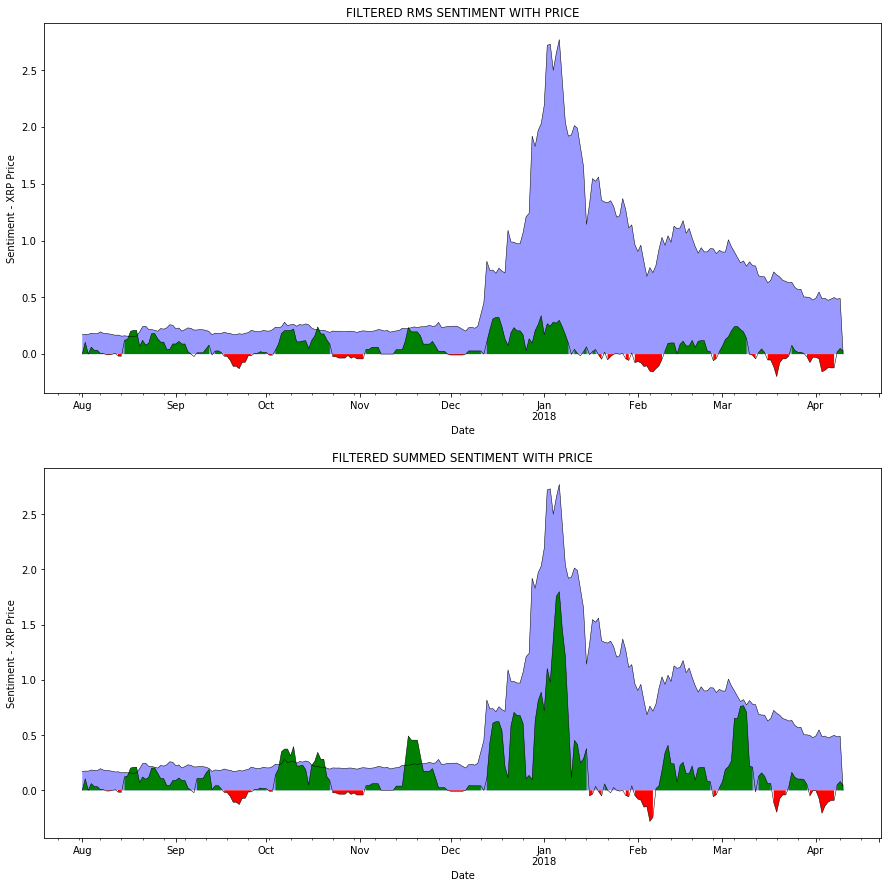

In [41]:
plt.subplots(nrows = 2, ncols = 1, figsize = (15,15))
ax1 = plt.subplot(211)
df4.XRP_Price.plot(color = 'k', lw = 0.5, ax = ax1)
ax1.fill_between(df4.index, np.zeros(len(df4)),df4.XRP_Price, alpha = 0.4, facecolor = 'b')
df4.RMS_box_filter.plot(color = 'k', lw = 0.5, ax = ax1)
ax1.fill_between(df4.index, np.zeros(len(df4)), df4.RMS_box_filter, where = (df4.RMS_box_filter >=0), facecolor = 'g')
ax1.fill_between(df4.index, np.zeros(len(df4)), df4.RMS_box_filter, where = (df4.RMS_box_filter <=0), facecolor = 'r')
ax1.set_title('FILTERED RMS SENTIMENT WITH PRICE')
ax1.set_ylabel('Sentiment - XRP Price')


ax2 = plt.subplot(212)
df4.XRP_Price.plot(color = 'k', lw = 0.5, ax = ax2)
ax2.fill_between(df4.index, np.zeros(len(df4)), df4.XRP_Price, alpha = 0.4, facecolor = 'b')
df4.Summed_box_filter.plot(color = 'k', lw = 0.5, ax = ax2)
ax2.fill_between(df4.index, np.zeros(len(df4)), df4.Summed_box_filter, where = (df4.Summed_box_filter >= 0), facecolor = 'g')
ax2.fill_between(df4.index, np.zeros(len(df4)), df4.Summed_box_filter, where = (df4.Summed_box_filter <= 0), facecolor = 'r')
ax2.set_title('FILTERED SUMMED SENTIMENT WITH PRICE')
ax2.set_ylabel('Sentiment - XRP Price')
plt.show()


It's safe to assume at this point that we can neglect the Sentiment RMS and Sentiment averaged statistics. They're not generalizing very well to the change XRP Price like Sentiment Summed is. With our sentiment now represented as a 5 day average, we have smoothed out the curve while still generalzing to the XRP Price. Let's create a correlation matrix and see if we have improved or corr score from earlier with regards to XRP Price and Sentiment

In [42]:
corr = df4.corr()
corr.loc['XRP_Price', 'Summed_box_filter']

0.6031529324029806

Our original correlation value between XRP Price and Summed Sentiment was 0.36, but now, by taking in account previous days' sentiment into today's value, we have imporved our correlation score to 0.61. Almost a 100% improvement. Next, let's see how XRP Trading volume plays a factor in conjunction with Sentiment

In [43]:
colors = ['g']
for i in range(1,len(df4)):
    if df4.XRP_Vol[i] > df4.XRP_Vol[i-1]:
        colors.append('g')
    else:
        colors.append('r')

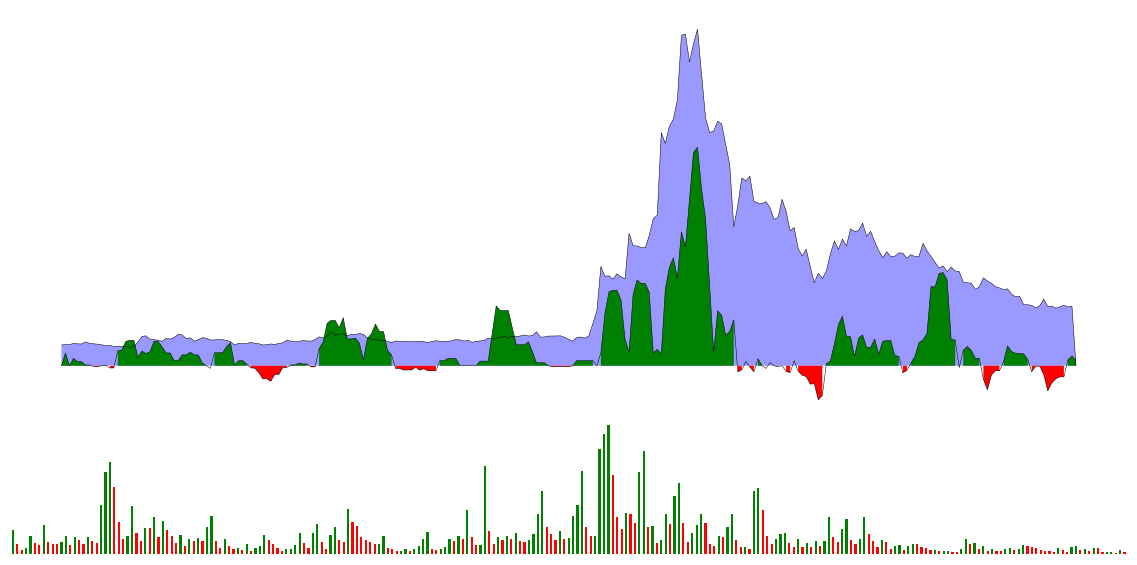

In [44]:
gs = GridSpec(4,1)
gs.update(hspace = 0)


ax = plt.subplot(gs[:3,:])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
df4.XRP_Price.plot(color = 'k', lw = 0.5, ax = ax, figsize = (20,10))
ax.fill_between(df4.index, np.zeros(len(df4)), df4.XRP_Price, alpha = 0.4, facecolor = 'b')
df4.Summed_box_filter.plot(color = 'k', lw = 0.5, ax = ax)
ax.fill_between(df4.index, np.zeros(len(df4)), df4.Summed_box_filter, where = (df4.Summed_box_filter >= 0), facecolor = 'g')
ax.fill_between(df4.index, np.zeros(len(df4)), df4.Summed_box_filter, where = (df4.Summed_box_filter <= 0), facecolor = 'r')

ax1 = plt.subplot(gs[-1,:])
ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
df4.XRP_Vol.plot(kind = 'bar', ax = ax1, color = colors)


plt.show()

It appears that a huge spike in volume almost always precedes a spike in sentiment. Especially when looking at XRP's first huge jump in price, volume spiked to it's highest level the day before. The next day, Sentiment also spiked to high numbers. Also take note that the highest trading volume didn't happen at XRP's highest price point. In actuality, trading volume was in a huge decline pattern as XRP was spiking out. This is a reasonable trend as one could speculate that as prices shot up, people weren't buying in as much for they might of speculated they missed the optimum buy in point, or they were simply waiting for a price correction. Therefore it appears that Sentiment was the sole driver for the price spike to its highest point since volume was in a decline. Next, let's continue this trend with incorporating past days' values into today's statistics. Another driver in an investor's decision making process is not an investment's performance day to day, but week to week or month to month. Therefore, let's perform our own Price Percent Change Statistics on the XRP Price. The data extracted online is a day to day price change percentage. We will now perform a 5, 10, 15, 20 and 30 day performance statistic

In [45]:
def rolling_average(df):
    a = df.copy()
    c = a['XRP_Price']
    five = a['XRP_Change']
    five[0] = 0
    ten = five.copy()
    fifteen = five.copy()
    twenty = five.copy()
    thirty  = five.copy()
    
    for i in range(1,len(five)):
        if i < 4:
            five[i] = (c[i] - c[0]) / c[0]
        else:
            five[i] = (c[i] - c[i-4]) / c[i-4]
        
    for i in range(1,len(ten)):
        if i < 9:
            ten[i] = (c[i] - c[0]) / c[0]
        else:
            ten[i] = (c[i] - c[i-9]) / c[i-9]
        
    for i in range(1,len(fifteen)):
        if i < 14:
            fifteen[i] = (c[i] - c[0]) / c[0]
        else:
            fifteen[i] = (c[i] - c[i-14]) / c[i-14]
            
    for i in range(1,len(twenty)):
        if i < 19:
            twenty[i] = (c[i] - c[0]) / c[0]
        else:
            twenty[i] = (c[i] - c[i-19]) / c[i-19]
        
    for i in range(1,len(thirty)):
        if i < 29:
            thirty[i] = (c[i] - c[0]) / c[0]
        else:
            thirty[i] = (c[i] - c[i-29]) / c[i-29]
        
    data = {'five day percent change': five, 'ten day percent change':ten , 'fifteen day percent change':fifteen, 'twenty day percent change':twenty, 'thirty day percent change':thirty, 'price':a.XRP_Price}
    df = pd.DataFrame(data)
    return df

In [46]:
data = rolling_average(df4)
data.head(30)

,fifteen day percent change,five day percent change,price,ten day percent change,thirty day percent change,twenty day percent change
Date,,,,,,
2017-08-01,0.000000,0.000000,0.1704,0.000000,0.000000,0.000000
2017-08-02,0.024648,0.024648,0.1746,0.024648,0.024648,0.024648
2017-08-03,0.018779,0.018779,0.1736,0.018779,0.018779,0.018779
2017-08-04,0.079812,0.079812,0.1840,0.079812,0.079812,0.079812
2017-08-05,0.058099,0.058099,0.1803,0.058099,0.058099,0.058099
2017-08-06,0.050469,0.025200,0.1790,0.050469,0.050469,0.050469
2017-08-07,0.149648,0.128456,0.1959,0.149648,0.149648,0.149648
2017-08-08,0.076291,-0.003261,0.1834,0.076291,0.076291,0.076291
2017-08-09,0.061033,0.002773,0.1808,0.061033,0.061033,0.061033


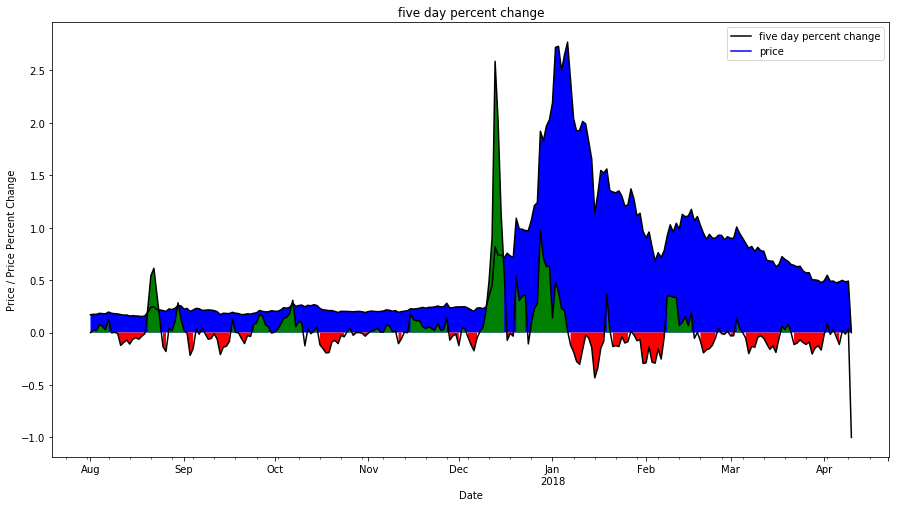

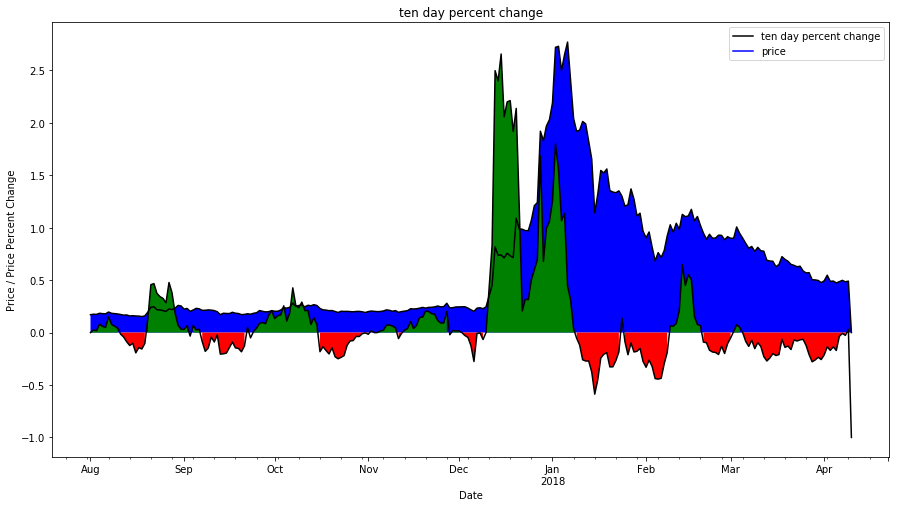

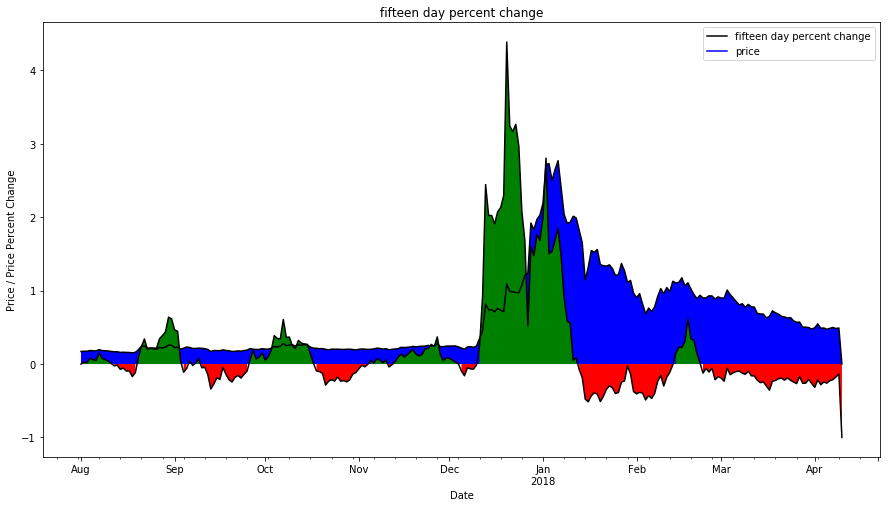

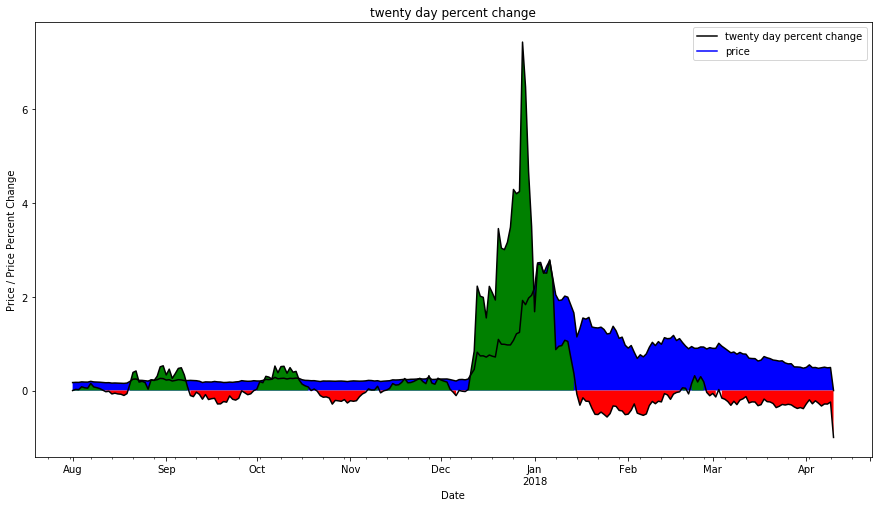

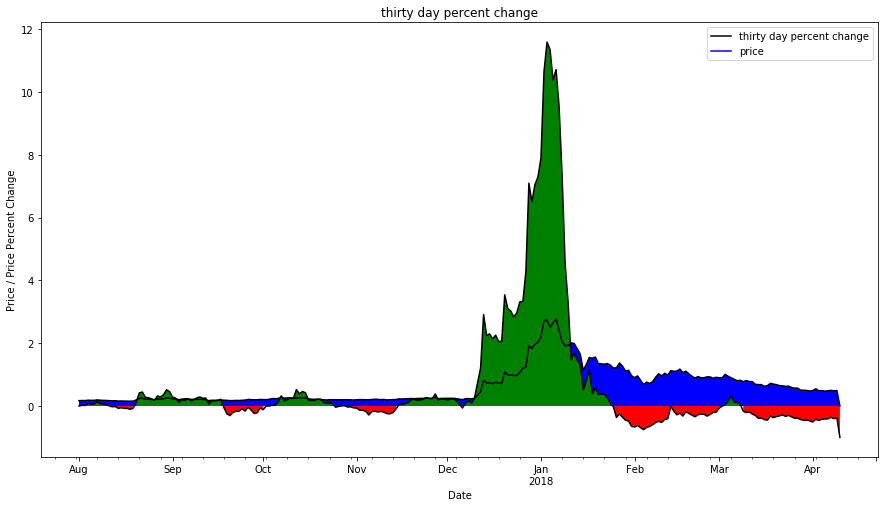

In [47]:
idx = [1,3,0,5,4]
for i in idx:
    data[[data.columns[i],'price']].plot(color = ['k','k'], figsize = (15,8))
    plt.fill_between(data.index, np.zeros(len(data)), data.price, facecolor = 'b')
    plt.fill_between(data.index, np.zeros(len(data)), data[data.columns[i]], where = (data[data.columns[i]] >=0), facecolor = 'g')
    plt.fill_between(data.index, np.zeros(len(data)), data[data.columns[i]], where = (data[data.columns[i]] <=0), facecolor = 'r')
    plt.ylabel('Price / Price Percent Change')
    plt.title(data.columns[i])
    
    ax = plt.gca()
    leg = ax.get_legend()
    leg.legendHandles[0].set_color('black')
    leg.legendHandles[1].set_color('blue')

    
    plt.show()

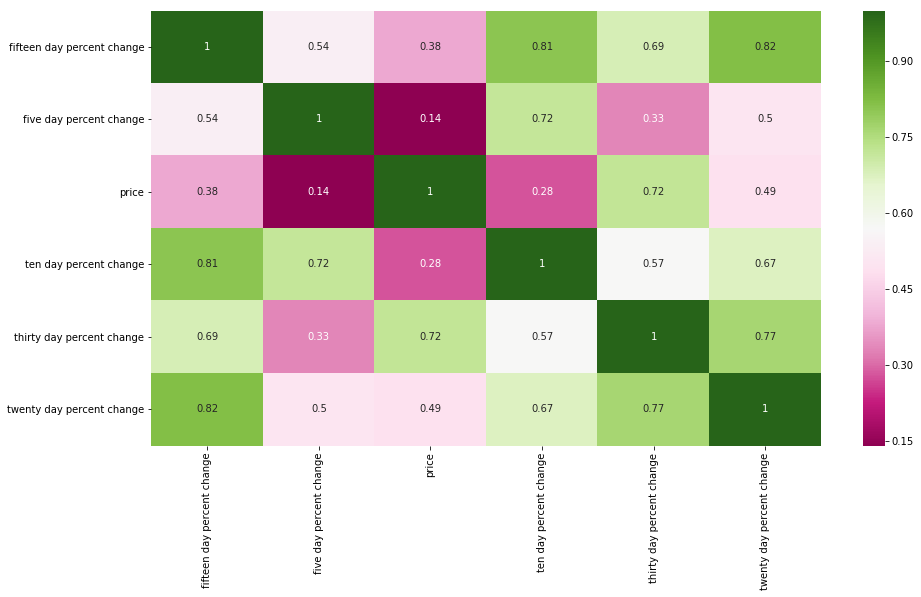

In [48]:
plt.figure(figsize = (15,8))
sns.heatmap(data.corr(), annot = True, cmap="PiYG")
plt.show()

It appears that the 30 day performance metric correlates very well XRP Price. This makes sense in that the typical investor would get more insight from long term trends than short day price swings. With a correlation of 0.72 at the 30 day performance metric, we have imporve our statistic from  -0.0786, a 1000% score improvement. A long term insight is always good to have, however a good investor shouldn't lose sight of the short term. For instance, someone more interested in shorting the investment instead of being long could've potentially made a 54% return on investment on August 22nd within a 5 day span. Whereas an investor going long would've had a ROI of only 35% in a 30 day span. 35% is nothing to scoff at, but at 6x the wait of the short term investor and a defecit of of almost 20% ROI, going long shouldn't be the only focus. Let's take the 10 day and 30 day performance and merge it with the original data and see how the correlations improve or decline from the original analysis.

In [49]:
a = data[['ten day percent change','thirty day percent change']]
b = pd.merge(df3, a, how = 'outer', left_index = True, right_index = True)
corr = b.corr()
corr[corr[['ten day percent change','thirty day percent change']] > 0.3][['ten day percent change', 'thirty day percent change']].dropna()

,ten day percent change,thirty day percent change
Positive Sentiment Averaged,0.328236,0.305421
Positive Sentiment Summed,0.315451,0.520332
Overall Sentiment Summed,0.380837,0.503136
Positive Sentiment RMS,0.318143,0.318680
BTC_High,0.469728,0.536958
BTC_Low,0.486588,0.534216
BTC_Open,0.465935,0.539035
BTC_Price,0.480219,0.540522
ten day percent change,1.000000,0.570715
thirty day percent change,0.570715,1.000000


The correlation matrix above was filtered to reveal only those correlations greater than 0.3. Again, the 30 day performance statistic performs better than the 10 day performance statistic. So let's compare the 30 day performance statistic with XRP Price overall to determine if it there's more of a correlation between predicting percent change or an actual price.

In [50]:
corr[corr.XRP_Price > 0.3][['XRP_Price','thirty day percent change']]

,XRP_Price,thirty day percent change
Positive Sentiment Summed,0.474611,0.520332
Overall Sentiment Summed,0.367908,0.503136
Positive Sentiment RMS,0.306076,0.318680
XRP_High,0.979084,0.693977
XRP_Low,0.971130,0.650788
XRP_Open,0.968195,0.650594
XRP_Price,1.000000,0.722334
BTC_High,0.705052,0.536958
BTC_Low,0.706391,0.534216
BTC_Open,0.712868,0.539035


XRP Price is still the stronger dependent variable to predict. Again the above correlation matrix was filtered to reveal only those variables that have a correlation coeffecient greater than 0.3. Still, trying to predict an exact price might be too difficult. A little more reasonable might be predicting a price range. Let's convert the XRP Prices to price ranges

In [51]:
data, bins = pd.cut(b.XRP_Price, bins = 50, retbins = True, labels = range(50))
print(bins)
print(data[0:30])

[-0.00277  0.0554   0.1108   0.1662   0.2216   0.277    0.3324   0.3878
  0.4432   0.4986   0.554    0.6094   0.6648   0.7202   0.7756   0.831
  0.8864   0.9418   0.9972   1.0526   1.108    1.1634   1.2188   1.2742
  1.3296   1.385    1.4404   1.4958   1.5512   1.6066   1.662    1.7174
  1.7728   1.8282   1.8836   1.939    1.9944   2.0498   2.1052   2.1606
  2.216    2.2714   2.3268   2.3822   2.4376   2.493    2.5484   2.6038
  2.6592   2.7146   2.77   ]
Date
2017-08-01    3
2017-08-02    3
2017-08-03    3
2017-08-04    3
2017-08-05    3
2017-08-06    3
2017-08-07    3
2017-08-08    3
2017-08-09    3
2017-08-10    3
2017-08-11    3
2017-08-12    2
2017-08-13    3
2017-08-14    2
2017-08-15    2
2017-08-16    2
2017-08-17    2
2017-08-18    2
2017-08-19    2
2017-08-20    3
2017-08-21    4
2017-08-22    4
2017-08-23    3
2017-08-24    3
2017-08-25    3
2017-08-26    3
2017-08-27    4
2017-08-28    3
2017-08-29    4
2017-08-30    4
Name: XRP_Price, dtype: category
Categories (50, int64)

XRP Price has been cut into 50 different ranges that are shown above. The ranges have been labeled 0 - 49 and correspond as follows:
> (0.149825 - 0.20485] = bin 0

> (0.20485 - 0.2572] = bin 1

> (0.2572 - 0.30955] = bin 2

> etc

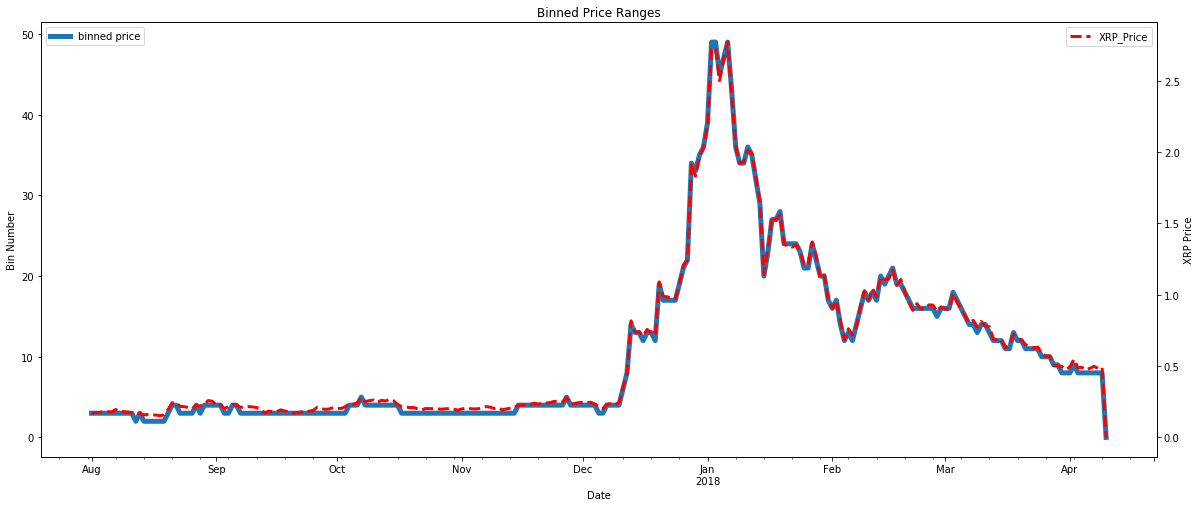

In [55]:
ax = b['binned price'].plot(figsize = (20,8), lw = 5)
plt.ylabel('Bin Number')
plt.title('Binned Price Ranges')
plt.legend(loc = 2)
ax2 = ax.twinx()
b.XRP_Price.plot(color = 'r', linestyle = '--', lw = 3)
plt.ylabel('XRP Price')
plt.legend()
plt.show()

In [56]:
b['binned price'] = data.astype(int)
corr = b.corr()
corr[corr > 0.3][['binned price','XRP_Price']].dropna()

,binned price,XRP_Price
Positive Sentiment Summed,0.479032,0.474611
Overall Sentiment Summed,0.372903,0.367908
Positive Sentiment RMS,0.309205,0.306076
XRP_High,0.978877,0.979084
XRP_Low,0.971074,0.971130
XRP_Open,0.967652,0.968195
XRP_Price,0.999626,1.000000
BTC_High,0.705638,0.705052
BTC_Low,0.707170,0.706391
BTC_Open,0.713364,0.712868


The binned prices haven't improved any correlation coeffecients, but they also haven't degraded them either. Because of this, it still might be more feasible to utilize ranges when predicting XRP Price for accuracy sake. From our analysis, we have plenty of variables that affect our dependent variable (XRP Price). For the next step, we will create some machine learning models utilizing the insights we have gained here from this EDA.

# Save data to CSV

In [57]:
b.to_csv('XRP_Data.csv')